<a href="https://colab.research.google.com/github/the-SQuAD-squad/QA/blob/rnn/QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Project
## RNN classification and precedence

Buiani, Serfilippi, Verì, Rambaldi


In [ ]:
#@title Init { form-width: "25%" }
import os
import random
import math
import numpy as np
import tensorflow as tf
import json
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

pd.set_option('display.max_colwidth', None)

# fix random seeds
seed_value = 42 #@param {type:"integer"}

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

!nvidia-smi

Tue Mar  9 20:53:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    37W / 250W |    349MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Preprocessing

Or skip preprocessing below

In [ ]:
#@title df creation { form-width: "25%" }

# SQuAD v1.1 download from the rajpurkar official repo
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json -q -O training_set.json

with open("training_set.json", "r") as f:
    json_file = json.load(f)
data = json_file["data"]

rows = []
for document in data:
  for par in document['paragraphs']:
    for qas in par['qas']:
      rows.append({
        'id' : qas['id'],
        'title': document["title"],
        'passage': par['context'],
        'question' : qas['question'],
        'answer_idx' : (qas['answers'][0]['answer_start'], 
                    qas['answers'][0]['answer_start'] + len(qas['answers'][0]['text'])),
        'answer_text' : qas['answers'][0]['text']
      })

df_original = pd.DataFrame(rows)

In [ ]:
#@title preprocessing { form-width: "25%" }

import nltk
import re 
import math
import random as rand

def preprocess_text(text):
    """
    Given an iterable containing sentences, pre-process each sentence.

    :param: 
        - text: list of text to be pre-processed (Iterable)
    :return:
        - text: pre-processed text (List)
    """

    REPLACE_WITH_SPACE = re.compile(r"\n") 
    text = [REPLACE_WITH_SPACE.sub(" ", line) for line in text]

    # we don't remove symbols, but just put a space before and after them. 
    # We do this because we noticed that Glove contains an embedding also for
    # them, so, in this way, we are able to split these symbols from the text when computing sentence tokens
    text = [re.sub(r"([(.;:!\'ˈ~?,\"(\[\])\\\/\-–\t```<>_#$€@%*+—°′″“”×’^₤₹‘])", r' \1 ', line) for line in text]

    # We noticed that in the text sometimes we find numbers and the following word merged together (ex: 1980february),
    # so we put a space between the number and the word
    text = [re.sub(r"(\d+)([a-z]+)", r'\1 \2', line) for line in text] 
    text = [re.sub('\s{2,}', ' ', line.strip()) for line in text]   # replacing more than one consecutive blank spaces with only one of them

    return text

# Creating a copy of the original dataframe (to be able to compare processed and original data)
df = df_original.copy()

# Pre-process passage and question text
df['passage'] = preprocess_text(df_original['passage'])
df['question'] = preprocess_text(df_original['question'])
df['answer_text'] = preprocess_text(df_original['answer_text'])

# Comparing Original and Pre-Processed
for i in range(3):
    a = rand.randint(0,1000)
    print('ORIGINAL AND PREPROCESSED PASSAGE:')
    print(df_original.iloc[a]['passage'])
    print(df.iloc[a]['passage'])
    
    print()
    print('ORIGINAL AND PREPROCESSED QUESTION:')
    print(df_original.iloc[a]['question'])
    print(df.iloc[a]['question'])
    print()

ORIGINAL AND PREPROCESSED PASSAGE:
In 2015 Beyoncé signed an open letter which the ONE Campaign had been collecting signatures for; the letter was addressed to Angela Merkel and Nkosazana Dlamini-Zuma, urging them to focus on women as they serve as the head of the G7 in Germany and the AU in South Africa respectively, which will start to set the priorities in development funding before a main UN summit in September 2015 that will establish new development goals for the generation.
In 2015 Beyoncé signed an open letter which the ONE Campaign had been collecting signatures for ; the letter was addressed to Angela Merkel and Nkosazana Dlamini - Zuma , urging them to focus on women as they serve as the head of the G7 in Germany and the AU in South Africa respectively , which will start to set the priorities in development funding before a main UN summit in September 2015 that will establish new development goals for the generation .

ORIGINAL AND PREPROCESSED QUESTION:
An important UN summ

In [ ]:
#@title answer word idx + error catching { form-width: "25%" }

unwanted_rows = set()   # this set will contain the indices of rows containing errors (thus we will remove these rows from the dataframe)
unwanted_id = set()    # this set will contain the IDs of rows containing errors 
word_idx = []   # will contain the start and end indices of each answer in the corresponing passage
impossible_count = 0

print("Parsing dataset for answer errors")
for i in tqdm(df_original.index):

    # extracting one answer and the corresponding passage
    answer = np.array(df["answer_text"][i].split())
    passage = np.array(df["passage"][i].split())

    l = len(answer)
    idx = []    # this list will contain the start and end indices of the answer occurrence in the corresponding passage (these could be more than 1! ex: we find the answer "rome" in 2 distinct positions in the same passage)
    counts = []     # counts will contain how many characters there are before the answer start in the passage
    char_count = 0
    for j in range(len(passage)-l+1):   # for each token in the passage, check if the answer starts from that token
        if (answer == passage[j:j+l]).all():
            idx.append((j, j+l))    # j is the start_index and j+l is the end_index of the answer in the passage
            counts.append(char_count)    # char_count is the count of characters before the start of the answer
        char_count += len(passage[j])
    if len(counts) == 0:    # no answer found in the passage. Probably there is an error in the dataset (for instance the answer is "7", but in the text it is written like "seven")
        unwanted_rows.add(i)
        unwanted_id.add(df_original["id"][i])
        word_idx.append((-1, -1))   # stating that there was an error
        impossible_count+=1

    else:   # answer found in the passage
        # if more than one answer correspondence was found in the passage, we take the one whose start index is nearer the start index given in the dataset 
        # (these 2 starting indices do not match perfectly because we are working on the preoprocessed text, so our starting index is a little bit different from the original)
        n_spaces_original = df_original["passage"][i][:df_original["answer_idx"][i][0]].count(" ")    # counting how many spaces there are in the original passage before the answer
        n_newline_original = df_original["passage"][i][:df_original["answer_idx"][i][0]].count("\n")    # counting how many newline characters there are in the original passage before the answer
        s = np.abs(np.array(counts)-(df["answer_idx"][i][0]-n_spaces_original-n_newline_original))

        if (0 not in s) and len(s)>1:   # in this case the answer was found in the passage, but the start index specified in the dataset is not the right one (it indicates a wrong occurrence of the answer)
            unwanted_rows.add(i)
            unwanted_id.add(df_original["id"][i])
            word_idx.append((-1, -1))   # stating that there was an error
            impossible_count+=1

        else:
            word_idx.append(idx[np.argmin(s)])

print(f"Removing {impossible_count} rows containing errors.")

# adding a new column to the dataframe containing the word indices of the answer in the splitted passage
df["word_idx_answer"] = word_idx
df["passage"]=df["passage"].str.lower()
df["question"]=df["question"].str.lower()
df["answer_text"]=df["answer_text"].str.lower()

Parsing dataset for answer errors



Removing 231 rows containing errors.


In [ ]:
#@title build vocaulary { form-width: "25%" }

import numpy as np

def build_vocabulary(text):
    """
    Given a list of words, builds the corresponding word vocabulary and the mappings from words to indices and vice-versa.

    :param: 
        - text: list of words from which we want to build the vocabularies (List)
    :return:
        - idx2word: index to word mapping (Dict)
        - word2idx: word to index mapping (Dict)
        - set_vocab: set of unique terms that build up the vocabulary
    """

    # Creating a set to eliminate repeated words
    set_vocab = ['<PAD>']+sorted(set(text)) # here we add the padding token as the first element of the set

    # Creating a mapping from unique words to indices
    word2idx = {u:i for i, u in enumerate(set_vocab)}   # the padding token will have 0 index
    # Creating a mapping from indices to unique words
    idx2word = {i:u for i, u in enumerate(set_vocab)}

    return idx2word,word2idx,set_vocab

# Creating a list containing all the passage and question text splitted in words
text =  ' '.join(np.concatenate((df['passage'],df['question']))).split(' ')
# Displaying first 100 words
print(text[:100])
# calling the build_vocabulary function to obtain the vocab and the mappings
idx_to_word, word_to_idx, word_listing = build_vocabulary(text)

print('[Debug] Index -> Word vocabulary size: {}'.format(len(idx_to_word)))
print('[Debug] Word -> Index vocabulary size: {}'.format(len(word_to_idx)))
print('[Debug] Some words: {}'.format([(idx_to_word[idx], idx) for idx in np.arange(100)]))

['architecturally', ',', 'the', 'school', 'has', 'a', 'catholic', 'character', '.', 'atop', 'the', 'main', 'building', "'", 's', 'gold', 'dome', 'is', 'a', 'golden', 'statue', 'of', 'the', 'virgin', 'mary', '.', 'immediately', 'in', 'front', 'of', 'the', 'main', 'building', 'and', 'facing', 'it', ',', 'is', 'a', 'copper', 'statue', 'of', 'christ', 'with', 'arms', 'upraised', 'with', 'the', 'legend', '"', 'venite', 'ad', 'me', 'omnes', '"', '.', 'next', 'to', 'the', 'main', 'building', 'is', 'the', 'basilica', 'of', 'the', 'sacred', 'heart', '.', 'immediately', 'behind', 'the', 'basilica', 'is', 'the', 'grotto', ',', 'a', 'marian', 'place', 'of', 'prayer', 'and', 'reflection', '.', 'it', 'is', 'a', 'replica', 'of', 'the', 'grotto', 'at', 'lourdes', ',', 'france', 'where', 'the', 'virgin', 'mary']
[Debug] Index -> Word vocabulary size: 82630
[Debug] Word -> Index vocabulary size: 82630
[Debug] Some words: [('<PAD>', 0), ('!', 1), ('"', 2), ('#', 3), ('$', 4), ('%', 5), ('&', 6), ("'", 7)

In [ ]:
#@title create GloVe embedding matrix { form-width: "25%" }

import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type, embedding_dimension=50):
    """
    Loads a pre-trained word embedding model via gensim library.

    :params:
        - model_type: name of the word embedding model to load.
        - embedding_dimension: size of the embedding space to consider

    :return:
        - pre-trained word embedding model (gensim KeyedVectors object)
    """

    download_path = ""

    # Find the correct embedding model name
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)

    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove")

    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model


def check_OOV_terms(embedding_model, word_listing):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :params:
        - embedding_model: pre-trained word embedding model (gensim wrapper)
        - word_listing: dataset specific vocabulary (list)

    :return:
        - list of OOV terms
    """
    # Creating a list for the OOV words
    oov = []
    for word in word_listing:
        # Checking if the word is in the embedding_model
        if word not in embedding_model:
            oov.append(word)
    return oov


def build_embedding_matrix_w_random(embedding_model, embedding_dimension, word_to_idx, oov_terms):
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :params: 
        - embedding_model: pre-trained word embedding model (gensim wrapper)
        - word_to_idx: vocabulary map (word -> index) (dict)
        - oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = []
    for word in tqdm(word_to_idx):
        if word in oov_terms:
            embedding_matrix.append(np.random.rand(embedding_dimension))
        else:
             embedding_matrix.append(embedding_model[word])
    return np.array(embedding_matrix)

# we used Glove with embedding dimension 100 for our final tests
embedding_model_type = "GloVe"
embedding_dimension = 100
embedding_model = load_embedding_model(embedding_model_type, embedding_dimension)

# checking how many OOV terms we have
oov_terms = check_OOV_terms(embedding_model, word_listing)

print("Total OOV terms: {0} ({1:.2f}%)".format(len(oov_terms), len(oov_terms)/len(word_listing)*100))

embedding_matrix = build_embedding_matrix_w_random(embedding_model, embedding_dimension, word_to_idx, oov_terms)

print("Embedding matrix shape: {}".format(embedding_matrix.shape))

print("Some OOV terms: ", oov_terms[:100])   # this was useful to understand if we could improve pre-processing

Total OOV terms: 15985 (19.35%)



Embedding matrix shape: (82630, 100)
Some OOV terms:  ['<PAD>', '0000222556', '000a', '000rmb', '0018', '0028', '0029670', '0042', '0043', '0054', '0065', '0071', '0079', '00794', '00b7', '00e9', '012f', '0243', '0307', '0358', '036', '042', '057', '058', '05946', '062', '064', '066', '067', '069', '073', '078', '079', '083', '085', '088', '096', '097', '0fm', '100l', '10217', '10925', '10ffff', '10z', '10¢', '10−10', '10−12', '10−19', '10−2', '10−3', '10−34', '10−6', '10−8', '10−9', '1101010', '11092', '11114', '11172', '11246', '12232', '12291', '122ad', '1234567', '12750', '130h', '130j', '131\u202f000', '133cs', '13500', '13526', '13818', '145a', '146a', '14fdr', '14−17', '15408', '16041', '16384', '177847', '178b', '17½', '17\u202f000', '180ad', '18578', '1881−82', '1911a1', '1967a', '1967b', '197bc', '19n', '19sc111', '19˚n', '19˚s', '1fm', '1n4148', '1q08', '1\u202f800', '1⁄10', '1⁄14', '1⁄2']


In [ ]:
#@title dataset cleaning { form-width: "25%" }

# filters out question shorter than 10 characters
for i,question in enumerate(df['question']):
    if len(question)<=10:
        #print(df_original.iloc[i]) 
        #print(df_original['passage'][i])
        #print()
        unwanted_rows.add(i)
        unwanted_id.add(df["id"][i])

# ERROR CHECK before removing rows
print("Number of errors found: {0}\n".format(str(len(unwanted_id))))
some_error_id = random.sample(unwanted_id, 5)
for id in some_error_id:
    row_with_error = df_original[df_original["id"] == id].to_dict("list")
    print("Question: {0}".format(row_with_error["question"][0]))
    print("Passage: {0}".format(row_with_error["passage"][0]))
    print("Answer: {0}".format(row_with_error["answer_text"][0]))
    print("Answer extracted from: {0}".format(row_with_error["passage"][0][row_with_error["answer_idx"][0][0]-3:row_with_error["answer_idx"][0][1]+3]))
    print()

# Creating a txt file containing IDs of rows with errors for tutors
with open("error_IDs.txt", "a") as f:
    for error_id in unwanted_id:
        f.write(error_id + "\n")

df_clean = df.drop(list(unwanted_rows))
df_clean = df_clean.reset_index()

Number of errors found: 233

Question: What instrument did Anna Lelkes play?
Passage: In 1997, the Vienna Philharmonic was "facing protests during a [US] tour" by the National Organization for Women and the International Alliance for Women in Music. Finally, "after being held up to increasing ridicule even in socially conservative Austria, members of the orchestra gathered [on 28 February 1997] in an extraordinary meeting on the eve of their departure and agreed to admit a woman, Anna Lelkes, as harpist." As of 2013, the orchestra has six female members; one of them, violinist Albena Danailova became one of the orchestra's concertmasters in 2008, the first woman to hold that position. In 2012, women still made up just 6% of the orchestra's membership. VPO president Clemens Hellsberg said the VPO now uses completely screened blind auditions.
Answer: harp
Answer extracted from: as harpist

Question: What did John Milton do for world literature?
Passage: World literature was enriched by t

In [ ]:
#@title padding { form-width: "25%" }

# all sequences in train and val sets will be padded with a number of tokens equal to the maximum sentence length 
MAX_LENGTH_PASSAGE = len(max(df_clean['passage'], key=len))   
passages = [[word_to_idx[el] for el in sentence.split()] for sentence in df_clean['passage']]  # passages extraction
passages_pad = tf.keras.preprocessing.sequence.pad_sequences(passages, maxlen=MAX_LENGTH_PASSAGE, padding='post') # padding passages

MAX_LENGTH_QUESTION = len(max(df_clean['question'], key=len))   
questions = [[word_to_idx[el] for el in sentence.split()] for sentence in df_clean['question']]  # questions extraction
questions_pad = tf.keras.preprocessing.sequence.pad_sequences(questions, maxlen=MAX_LENGTH_QUESTION, padding='post') # padding questions

df_clean['passage_pad'] = list(passages_pad)
df_clean['question_pad'] = list(questions_pad)

# Skip preprocessing

In [ ]:
#@title load/store { form-width: "25%" }
import pickle
load = True #@param {type: "boolean"}

if load:
    !gcloud config set project feisty-mechanic-221914
    !gsutil cp gs://squad_squad/df_clean.pkl ./df_clean.pkl
    !gsutil cp gs://squad_squad/embedding_matrix.pkl ./embedding_matrix.pkl
    !gsutil cp gs://squad_squad/idx_to_word.pkl ./idx_to_word.pkl

    df_clean = pd.read_pickle("df_clean.pkl")
    with open('embedding_matrix.pkl', 'rb') as handle:
        embedding_matrix = pickle.load(handle)
    with open('idx_to_word.pkl', 'rb') as handle:
        idx_to_word = pickle.load(handle)
else:
    df_clean.to_pickle("df_clean.pkl")
    with open('embedding_matrix.pkl', 'wb') as handle:
        pickle.dump(embedding_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('idx_to_word.pkl', 'wb') as handle:
        pickle.dump(idx_to_word, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    from google.colab import auth
    auth.authenticate_user()
    
    !gcloud config set project feisty-mechanic-221914
    !gsutil cp ./df_clean.pkl gs://squad_squad/df_clean.pkl
    !gsutil cp ./embedding_matrix.pkl gs://squad_squad/embedding_matrix.pkl
    !gsutil cp ./idx_to_word.pkl gs://squad_squad/idx_to_word.pkl

!nvidia-smi

Updated property [core/project].
Copying gs://squad_squad/df_clean.pkl...
| [1 files][  1.4 GiB/  1.4 GiB]   43.9 MiB/s                                   
Operation completed over 1 objects/1.4 GiB.                                      
Copying gs://squad_squad/embedding_matrix.pkl...
- [1 files][ 63.0 MiB/ 63.0 MiB]                                                
Operation completed over 1 objects/63.0 MiB.                                     
Copying gs://squad_squad/idx_to_word.pkl...
/ [1 files][  1.1 MiB/  1.1 MiB]                                                
Operation completed over 1 objects/1.1 MiB.                                      
Tue Mar  9 20:54:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr

# Model

In [ ]:
#@title split { form-width: "25%" }

split_value = 0.1 #@param {type:"number"} 
val_dim = int(len(df_clean['title'].unique()) * split_value)
val_titles = np.random.choice(df_clean['title'].unique(), size=val_dim, replace=False)
passage_length = len(df_clean['passage_pad'][0])
question_length = len(df_clean['question_pad'][0])

# creating train and val sets
df_val = df_clean[df_clean['title'].isin(val_titles)]
df_train = df_clean[~(df_clean['title'].isin(val_titles))]

In [ ]:
#@title model definition { form-width: "25%" }

from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM
from tensorflow.keras.layers import Attention, concatenate, Dense, Softmax

def build_model():
    input_size=len(idx_to_word)
    embedding_dim=100
    encoding_units = 256
    dropout = 0

    input_passage = Input(shape=[None])
    input_question = Input(shape=[None])

    # EMBEDDING
    embedding = Embedding(input_size, embedding_dim, 
                          weights=[embedding_matrix],
                          trainable=False, mask_zero=True)   
    # trainable param is False because we use pre-trained Glove embeddings, 
    # mask_zero param is True because we have padding
    
    embedding_passage = embedding(input_passage)
    embedding_question = embedding(input_question)

    # ENCODING passage AND question
    encoding_passage = Bidirectional(LSTM(encoding_units,
                                          kernel_initializer='glorot_uniform',
                                          recurrent_initializer='orthogonal',
                                          dropout=dropout,
                                          stateful=False,
                                          return_sequences=True))(embedding_passage)   

    encoding_question = Bidirectional(LSTM(encoding_units,
                                           kernel_initializer='glorot_uniform',
                                           recurrent_initializer='orthogonal',
                                           dropout=dropout,
                                           stateful=False,
                                           return_sequences=True))(embedding_question)

    # ATTENTION LAYER
    query_value_attention_seq = Attention()([encoding_passage, encoding_question])   # out shape: [batch_size, passage_len, encoding_dim]
    combined = concatenate([encoding_passage, query_value_attention_seq])  # tried add but doesnt work

    lstm_start = Bidirectional(LSTM(encoding_units, 
                                    kernel_initializer='glorot_uniform',
                                    recurrent_initializer='orthogonal',
                                    dropout=dropout,
                                    stateful=False,
                                    return_sequences=True))(combined)


    output_start = Dense(1)(lstm_start)
    logits = tf.squeeze(output_start, axis=[2]) # shape (batch_size, seq_len)
    output_start = Softmax(name="answ_start")(logits)

    lstm_end = Bidirectional(LSTM(encoding_units, 
                                  kernel_initializer='glorot_uniform',
                                  recurrent_initializer='orthogonal',
                                  dropout=dropout,
                                  stateful=False,
                                  return_sequences=True))(combined)

    output_end = Dense(1)(lstm_end)
    logits = tf.squeeze(output_end, axis=[2]) # shape (batch_size, seq_len)
    output_end = Softmax(name="answ_end")(logits)

    out = tf.stack([output_start, output_end],axis=-1)
    model = tf.keras.Model([input_passage,input_question], outputs=[out])  

    model.summary()
    return model

In [ ]:
#@title metrics { form-width: "25%" }

def accuracy(y_true, y_pred):
    sampled = tf.argmax(y_pred, axis=-1)
    return 1 - tf.math.count_nonzero(tf.squeeze(tf.cast(y_true, tf.int64)) - sampled) / tf.cast(len(sampled), tf.int64)

def accuracy_start(y_true, y_pred):
    return accuracy(y_true[:,0], y_pred[:,:,0])

def accuracy_end(y_true, y_pred):
    return accuracy(y_true[:,1], y_pred[:,:,1])

def dist(y_true, y_pred):
    sampled = tf.argmax(y_pred, axis=-1)
    return tf.reduce_sum(tf.abs(tf.squeeze(tf.cast(y_true, tf.int64)) - sampled)) / tf.cast(len(sampled), tf.int64)

def mean_abs_dist_start(y_true_tuple, y_pred_tuple):
    return dist(y_true_tuple[:,0], y_pred_tuple[:,:,0])
    
def mean_abs_dist_end(y_true_tuple, y_pred_tuple):
    return dist(y_true_tuple[:,1], y_pred_tuple[:,:,1])

def exact_match(y_true, y_pred):
    sampled_start = tf.argmax(y_pred[:,:,0], axis=-1)
    sampled_end = tf.argmax(y_pred[:,:,1], axis=-1)
    start_diff = tf.cast(tf.math.abs(tf.cast(y_true[:,0], tf.int64) - sampled_start),tf.float32)
    end_diff = tf.cast(tf.math.abs(tf.cast(y_true[:,1], tf.int64) - sampled_end),tf.float32)
    count = tf.math.count_nonzero(tf.cast(start_diff + end_diff, tf.int64))
    return 1 - count / tf.cast(len(y_true), tf.int64)

In [ ]:
#@title train {form-width: "25%"}
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

ce = tf.keras.losses.SparseCategoricalCrossentropy()
β = 100

def custom_loss(y_true, y_pred):
    sampled_start = tf.argmax(y_pred[:,:,0], axis=-1)
    sampled_end = tf.argmax(y_pred[:,:,1], axis=-1)

    precedence_constraint = tf.math.maximum(sampled_start - sampled_end,
                                    tf.zeros(len(sampled_end), dtype=tf.int64)) / tf.cast(len(sampled_end), dtype=tf.int64)
    
    precedence_constraint = tf.cast(precedence_constraint, tf.float32)

    start_loss = ce(y_true[:,0], y_pred[:,:,0])
    end_loss = ce(y_true[:,1], y_pred[:,:,1])
    cross_entropy = start_loss + end_loss 

    return cross_entropy + β*precedence_constraint

batch_size = 16
epochs = 1000

ENABLE_WANDB = False        #@param {type:"boolean"}
wandb_experiment_name = "RNN_classification_final"  #@param {type: "string"}
if ENABLE_WANDB:
    os.environ["WANDB_SILENT"] = "true"
    !pip install wandb > /dev/null
    !wandb login wandb_api_token
    import wandb
    from wandb.keras import WandbCallback
    wandb.init(project="SQUAD", name=wandb_experiment_name)
    wandb.config.batch_size = batch_size
    wandb.config.epochs = epochs
    

saveDir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)
chkpt = saveDir + '/squad_check.hdf5'

es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, 
                        save_best_only=False, mode='auto', 
                        save_weights_only=True)

callbacks = [es_cb, cp_cb]

if ENABLE_WANDB:
    callbacks.append(WandbCallback(log_batch_frequency=10))

metrics = [accuracy_start, accuracy_end, mean_abs_dist_start, mean_abs_dist_end, exact_match]

model = build_model()
tf.keras.backend.clear_session()

model.compile(optimizer='adam', loss=custom_loss, metrics=metrics)

history = model.fit([np.stack(df_train['passage_pad']),np.stack(df_train['question_pad'])],np.stack(df_train['word_idx_answer'].to_numpy()), epochs=epochs,
                        callbacks=callbacks, validation_data=([np.stack(df_val['passage_pad']), np.stack(df_val['question_pad'])],np.stack(df_val['word_idx_answer'].to_numpy())),
                        batch_size=batch_size)

#Evaluation

In [ ]:
#@title load weights {form-width: "25%"}
model = build_model()

# pure classification
!wget https://api.wandb.ai/files/veri/SQUAD/51e4x276/model-best.h5
# constraint beta 100
#!wget https://api.wandb.ai/files/veri/SQUAD/m097whkn/model-best.h5
model.load_weights("model-best.h5")

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    8263000     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, None, 512)    731136      embedding_1[0][0]          

224/224 [==============================] - 46s 158ms/step
End before Start ratio: 9.93%


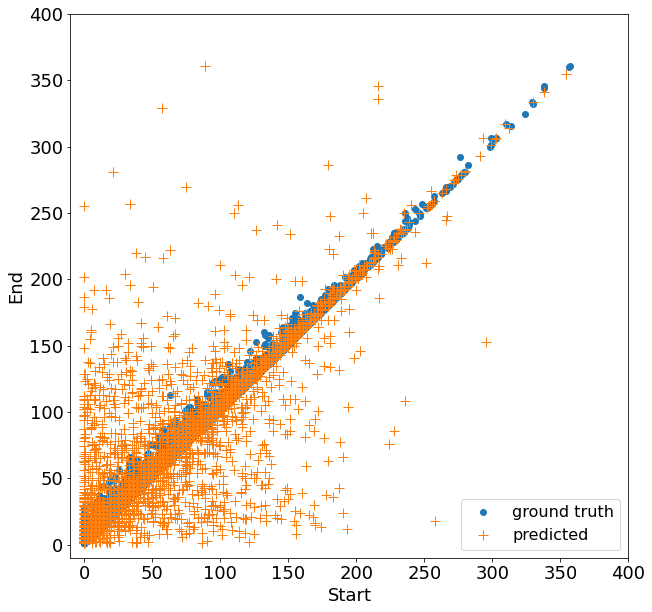

In [ ]:
#@title precedence plot {form-width: "25%"}

predictions = model.predict([np.stack(df_val['passage_pad']), 
                             np.stack(df_val['question_pad'])],
                             verbose=1)

sampled_start = np.argmax(predictions[:,:,0], axis=-1)
sampled_end = np.argmax(predictions[:,:,1], axis=-1)
plt.figure(figsize=(10,10))
plt.plot(np.stack(df_val['word_idx_answer'])[:,0],
         np.stack(df_val['word_idx_answer'])[:,1], 
         ".", markersize=12)
plt.plot(sampled_start, sampled_end,"+", markersize=10)
plt.legend(("ground truth", "predicted"), fontsize=16)

plt.ylim((-10,400))
plt.xlim((-10,400))

plt.xlabel('Start', fontsize=18)
plt.ylabel('End', fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

precedence_violation = sum(sampled_end - sampled_start < 0) / len(sampled_end)
print(f"End before Start ratio: {precedence_violation:.2%}")
